### wcdq demo

##### Author: Luiz Fernando de Frias (l.frias@poli.ufrj.br)

Here I'll show how I used the wcdq package for monitoring Data Quality for Web Crawlers at TWIST [1].

Specifically we'll invesgate two dimensions of data quality: completeness and coherence. The last includes accuracy and coherence, as defined by ISO 25012 [2].

[1] http://www.twistsystems.com/en/ <br/>
[2] http://iso25000.com/index.php/en/iso-25000-standards/iso-25012)

In [1]:
import datetime
import pandas
import pickle
import matplotlib.pyplot as plt
import numpy as np
import hashlib
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import dqutils as dq
import wcdq
import copy as cp
import qgrid
qgrid.nbinstall(overwrite=True)

matplotlib.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 20})
plt.style.use('seaborn-dark-palette')
%matplotlib inline

`dqutils` will not be available because it contains sensitive information for the company.

-----

### Extending wcdq

#### Introduction

wcdq comes with two ready to use DQ implementations, BaseDQ and DateDQ, which compute their dq scores, which should always be between 0 and 1, as follows.

BaseDQ
 - completeness: 0 if the attribute's value is empty, 1 otherwise
 - coherence: always assume consistency

DateDQ:
 - completeness: inherits from BaseDQ
 - coherence: 0 if date is in the future, 1 otherwise
 
Of course this is very limited, but the way we analyze dq dimensions is application specific and context related. Below I'll demonstrate how I've used wcdq for implementing other dq measures.

#### Context

First I'll explain the context.

TWIST Press [1] have a set of dashboards for presenting the outcomes of multiple analysis based on journalistic data. It can be described as a Data Product and as such it fits in ISO 25012 description: "The Quality of a Data Product may be understood as the degree to which data satisfy the requirements defined by the product-owner organization. Specifically, those requirements are the ones that are reflected in the Data Quality model through its characteristics (Accuracy, Completeness, Consistency, Credibility, Currentness, Accessibility...).". That means we should be defining rules for monitoring the quality of our crawled data. 

Documents stored in the database have the following fields: title, date_published, body, url and language.
After crawling them, they are processed into a knowledge extraction pipeline that includes topic extraction, NER and others. Results are then displayed in a web interface.

Let's define some rules for start.

##### 1. Title

We'll check for completeness and assume consistency. BaseDQ will suffice.

##### 2. Date published

The date when the news was published should be saved with hour information. When I'm not able to find hour among the date field I set it to 00:00. As DateDQ class won't handle this kind of behaviour, I'll extend its completeness rule.

##### 3. Body

Definitely the main source of data quality problems. As topic extraction is one of the steps in the processing pipeline we should validate these documents accordingly. 
- If it contains JavaScript we set coherence to zero since topic extraction will be lost. 
- We also check for syntax errors. If a misspelled word is present it'll probably cause problems.

##### 4. URL

Same of title attribute.

##### 5. Language

Language is rather important in my application. That's because the information extraction pipeline is language dependent and it'll be redirected accordingly. The language should of course match document's text.

**Important** Document's attributes don't necessarily have the same level of importance. Specifically in this context, document's attributes will be weighted by the number of algorithms they impact in our knowledge pipeline. 


| attribute      | weight |
|----------------|--------|
| title          | 2      |
| date_published | 2      |
| body           | 2      |
| url            | 1      |
| language       | 4      |

But remembering one of the multiple data quality definitions we can interpret data quality as “fitness for use” (Wang & Strong, 1996). It tells us that we shouldn't use such a general approach (ie, computing DQ score the whole database). Probably makes more sense computing DQ score for the more specific tasks. For instance: for computing the "confidence" of a topic extraction pipeline, we shouldn't be looking at url, title nor date_published. Body and language would have other weights assigned, their dq dimensions scores computations would be designed thinking especifically in the topic extraction task and it'd provide better results.

Finally, please notice this is rather an oversimplified approach and it's purpose is to illustrate how it can be easily extended. Now let's implement it!

    
[1] https://press.twistsystems.com/

Below you can find the described rules implemented

In [2]:
import re
from sklearn.externals import joblib
import string
from nltk.tokenize import word_tokenize

# Language detector
from langdetect import detect as ldetect

# Spelling checker
import enchant

# wcdq imports
from wcdq.dq import DateDQ, dparse
from wcdq import BaseDQ

class MyDateDQ(DateDQ):
        
    def get_completeness_score(self):
        """ Check for invalid date and 00:00 hour
        """
        if not self.value:
            return 0
        # Invalid date is a matter of coherence,
        # so return total completeness
        error = False
        try:
            d = dparse(self.value)
        except:
            error = True
        if error:
            return 1
        # Couldn't find hour in the page
        if d.hour == 0 and d.minute == 0:
            return 0.5
        # It's all good
        return 1

class BodyFeatureExtractor():
    
    def __init__(self):
        self.js_reserved_words = set([
            'instanceof', 'break', 'alert', 'function', 'hasOwnProperty',
            'Array', 'parseInt', 'clearInterval', 'clearTimeout', 'isPrototypeOf',
            'Date', 'decodeURI', 'decodeURIComponent', 'document' 'setInterval',
            'setTimeout', 'Math', 'encodeURI', 'encodeURIComponent', 'window',
            'margin', 'border', 'overflow', 'padding', 'width', 'height'
        ])
        
    def tokenize(self, doc):
        doc = doc.lower()
        return word_tokenize(doc)

    def extract_features(self, doc_tokens):
        punctuation_count, js_count = 0, 0
        for token in doc_tokens:
            if token in set([';', '{', '}']):
                punctuation_count += 1
            if token in self.js_reserved_words:
                js_count += 1
  
        features = [punctuation_count, js_count]
        return features

    
class BodyDQ(BaseDQ):
    
    def __init__(self, value, doc_data):
        self.value = value
        self.doc_data = doc_data
        super(BodyDQ, self).__init__(value, doc_data) 
    
    def extract_features(self):
        extractor = BodyFeatureExtractor()
        self.tokens = extractor.tokenize(self.value)
        features = extractor.extract_features(self.tokens)
        self.features = np.asarray(features).reshape(1, -1)
    
    def get_coherence_score(self):
        if self.get_completeness_score() == 0:
            return 1
        # If it has JS in the body
        self.extract_features()
        clf = joblib.load('models/js_clf.pkl')
        if clf.predict(self.features) == 1:
            return 0
        # Syntax error
        try:
            d = enchant.Dict({
                'en': 'en_US',
                'pt': 'pt_BR'
            }[self.doc_data.get('language')])
        # We don't have the dict in the system
        except KeyError:
            return 1
        
        doc_syntax = []
        for token in self.tokens:
            try:
                doc_syntax.append(d.check(token))
            except:
                pass
        # Correctness
        if len(doc_syntax) == 0:
            return 1
        return sum([el for el in doc_syntax])/len(doc_syntax)


class LanguageDQ(BaseDQ):
    
    def __init__(self, value, doc_data):
        self.value = value
        self.doc_data = doc_data
        super(LanguageDQ, self).__init__(value, doc_data) 
        
    def get_coherence_score(self):
        if self.get_completeness_score() == 0:
            return 1
        body = self.doc_data.get('body')
        ldetected = None
        try:
            if self.value != ldetect(body):
                return 0
        except:
            return 1
        return 1
    
attrs_mapping = {
    'title': {
        'class': BaseDQ,
        'weight': 2
    },
    'date_published': {
        'class': MyDateDQ,
        'weight': 2
    },
    'body': {
        'class': BodyDQ,
        'weight': 2
    },
    'url': {
        'class': BaseDQ,
        'weight': 1
    },
    'language': {
        'class': LanguageDQ,
        'weight': 4
    }
}

----

### Part 01 - DQ analysis for the whole database, bottom-down approach.

Given a time window let's compute data quality scores.

In [3]:
FROM_DATE = '2016-08-01'
TO_DATE = '2016-08-27'

First I'll take a look at how many documents I'll process so I have a time estimation for this task

In [4]:
spider_df = dq.get_spiders_by_interval(dq.es, FROM_DATE, TO_DATE)
# Filter so it won't take a lifetime
spider_df = spider_df[spider_df['documents'] > 2000]
qgrid.show_grid(spider_df)

From the plot below it's easy to see which spiders mostly contributes with database's quality score. 

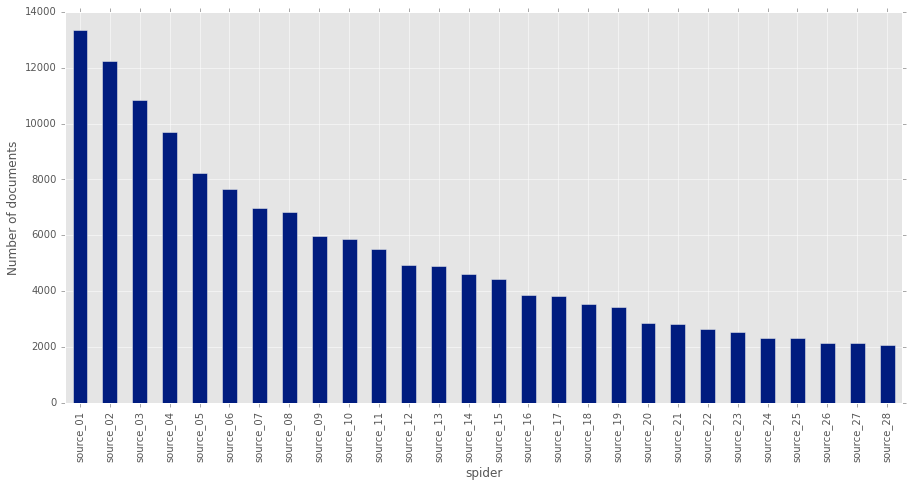

In [5]:
spider_df.plot(kind='bar', x='spider', figsize=(15, 7))
plt.ylabel('Number of documents')
plt.legend().remove()

So now that I'm aware of the number of documents I have, I'll compute the quality score the database, for the given time period.

In [7]:
%%time

# Let's create our database
db = wcdq.DB()

# Let's add Spiders
for irow, row in spider_df.iterrows():
    doc_count, spider = row['documents'], row['spider']
    print('Spider %s...' % spider, end='')

    s = wcdq.Spider(spider)
    s.set_dq(
        # We should specify dq dimensions
        ['completeness', 'coherence'],
        # Generator of documents
        dq.get_docs(dq.es, FROM_DATE, TO_DATE, s._id, attrs_mapping))
    # Now that we have DQ dimensions computed, add it to the DB
    db.add_spider(s)

    print('Ok!')

# Compute DQ score for the whole DB
db.ready()

Spider source_01...Ok!
Spider source_02...Ok!
Spider source_03...Ok!
Spider source_04...Ok!
Spider source_05...Ok!
Spider source_06...Ok!
Spider source_07...Ok!
Spider source_08...Ok!
Spider source_09...Ok!
Spider source_10...Ok!
Spider source_11...Ok!
Spider source_12...Ok!
Spider source_13...Ok!
Spider source_14...Ok!
Spider source_15...Ok!
Spider source_16...Ok!
Spider source_17...Ok!
Spider source_18...Ok!
Spider source_19...Ok!
Spider source_20...Ok!
Spider source_21...Ok!
Spider source_22...Ok!
Spider source_23...Ok!
Spider source_24...Ok!
Spider source_25...Ok!
Spider source_26...Ok!
Spider source_27...Ok!
Spider source_28...Ok!
CPU times: user 3h 25min 41s, sys: 2min 25s, total: 3h 28min 7s
Wall time: 3h 34min 43s


### Database quality score

We can compute DQ score for each DQ dimension.

In [8]:
db.get_dq()

,completeness,coherence
0,0.98285,0.978577


#### Questions may arise from this result. For instance:

1. Which spider mostly contributes to reduce each DQ dimension?
2. Which attribute from the documents mostly contributes to reduce each DQ dimension?

Let's answer them below.

#### Answer for Question 01

The first question will find its answer in the table.

In [9]:
db.describe(order_by='completeness', ascending=True).head(10)

,docs,completeness,coherence,weight
spider,,,,
source_14,4619,0.818064,1.000000,0.031078
source_12,4948,0.893180,0.992807,0.033291
source_10,5851,0.900157,0.979829,0.039367
source_11,5511,0.950908,0.968888,0.037079
source_01,13373,0.989062,0.984441,0.089976
source_24,2320,0.989498,0.984812,0.015609
source_20,2871,0.991926,0.969385,0.019317
source_26,2154,0.992403,0.969981,0.014493
source_05,8221,0.995345,0.970594,0.055313


Alternatively we can plot score for each spider, for each DQ dimension.

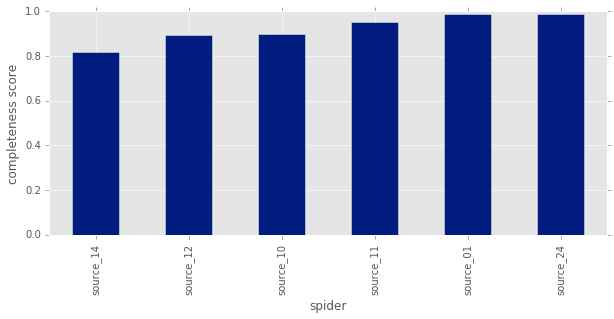

In [10]:
_ = db.plot_dq_by_spider('completeness', lower_than=.99, figsize=(10, 4))

It's easy to see how "source_14" has a much lower completeness score than others.

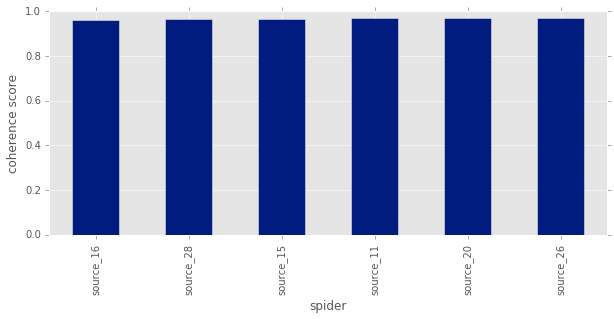

In [11]:
_ = db.plot_dq_by_spider('coherence', lower_than=.97, figsize=(10, 4))

On the contrary, coherence seems to be pretty good among all sources (or our metrics are too simple, which is way more probable).

#### Answer for Question 02

The second question has its answer in the table below as well.

In [12]:
db.get_dq_by_attrs(order_by=['completeness', 'coherence'], ascending=True)

,completeness,coherence
attr,,
body,0.917788,0.888498
title,0.989040,1.000000
date_published,0.998846,1.000000
language,1.000000,0.996838
url,1.000000,1.000000


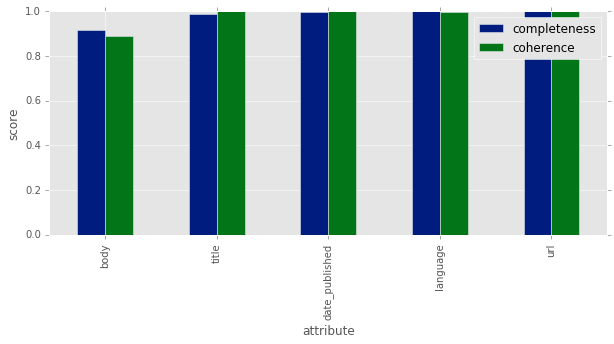

In [13]:
df = db.get_dq_by_attrs(order_by=['completeness'])

ax = df[['completeness', 'coherence']].plot(kind='bar', figsize=(10, 4))
ax.set_ylabel('score')
ax.set_xlabel('attribute')

Document's body is responsible for the decrease of completeness score.

### Spider quality score

From the analysis of database's quality we may further investigate a specific spider. This is interesting in case we have a dominant spider (ie, a spider with a much higher weight than the others) with a low quality score.

In [14]:
db.describe(order_by='weight')

,docs,completeness,coherence,weight
spider,,,,
source_01,13373,0.989062,0.984441,0.089976
source_02,12263,0.999785,0.970974,0.082508
source_03,10860,0.999322,0.984960,0.073068
source_04,9695,0.999587,0.970631,0.065230
source_05,8221,0.995345,0.970594,0.055313
source_06,7662,0.999585,0.985943,0.051552
source_07,6961,0.998563,0.970800,0.046835
source_08,6845,0.999920,0.985126,0.046055
source_09,5976,0.999361,0.983385,0.040208


We can see that "source_14" is somehow important for the database score and has a low completeness score if compared to the others. We can proceed with the analysis for this spider.

In [15]:
spider = db.get_spider('source_14')

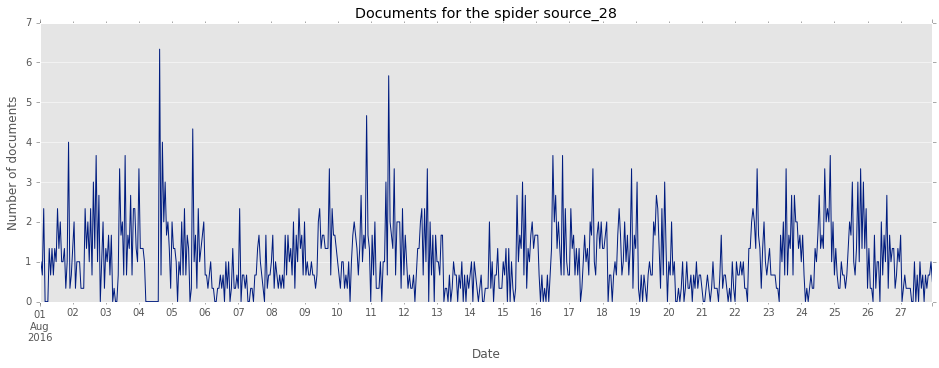

In [16]:
ax = s.get_ts().resample('1H').plot(figsize=(16,5))
ax.set_title('Documents for the spider %s' % s._id)
ax.set_ylabel('Number of documents')
ax.set_xlabel('Date')

#### Questions:

1. Which attribute from the docs mostly contributes to reduce DQ scores?
2. How attribute's quality score has evolved over time?

In [17]:
spider.get_dq(as_df=True)

,coherence,completeness
0,1.0,0.818064


#### Answer 01

Let's see which attribute is lacking of completeness.

In [18]:
spider.get_dq_by_attrs()

,attr,completeness,coherence
0,body,0.000000,1.0
1,date_published,0.999351,1.0
2,language,1.000000,1.0
3,title,1.000000,1.0
4,url,1.000000,1.0


#### Answer 02

We can further plot the evolution for the completeness score for the body.

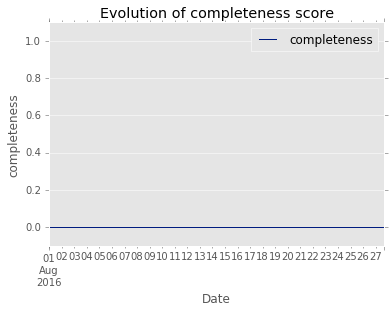

In [19]:
ax = spider.plot_dq_evolution_for_attr('completeness', 'body', freq='10H')
_ = ax.set_title('Evolution of completeness score')

So we were never able to parse "source_14" correctly.

-------------

Let's choose other spider. Now we'll look at "source_11" since it's the lower coherece score among the important spiders.

In [20]:
spider = db.get_spider('source_11')

In [21]:
spider.get_dq(as_df=True)

,coherence,completeness
0,0.968888,0.950908


In [22]:
spider.get_dq_by_attrs()

,attr,completeness,coherence
0,body,1.000000,0.891302
1,date_published,1.000000,1.000000
2,language,1.000000,0.968790
3,title,0.729995,1.000000
4,url,1.000000,1.000000


Again body is responsible for the decrease of score, but this time we're dealing with coherence.

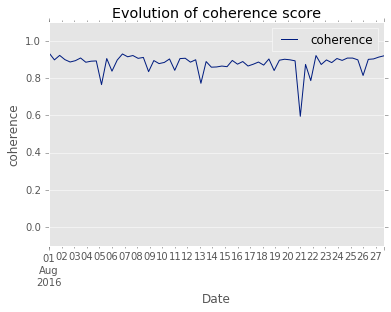

In [23]:
ax = spider.plot_dq_evolution_for_attr('coherence', 'body', freq='10H')
_ = ax.set_title('Evolution of coherence score')

In [24]:
spider.describe().head(6)

,doc_id,completeness,coherence
0,AVaoWKSI7dPddkMfjZE9,1.0,0.981427
1,AVaoazF97dPddkMfjZFs,1.0,0.974585
2,AVaokFfO7dPddkMfjZIU,1.0,0.991575
3,AVaokFjC7dPddkMfjZIV,1.0,0.982074
4,AVaokFjW7dPddkMfjZIW,1.0,0.987179
5,AVaokFjn7dPddkMfjZIX,1.0,0.573114


Strangely the coherence score is pretty inconsistent among documents. The reason for this will require further investigantion.

Document "AVaokFjn7dPddkMfjZIX" is responsible for the lowest score of coherence, let's see why.

### Document quality score

In [25]:
for doc in dq.get_docs(dq.es, FROM_DATE, TO_DATE, spider._id, attrs_mapping):
    if doc._id == 'AVaokFjn7dPddkMfjZIX':
        break
doc.set_dq(['completeness', 'coherence'])

Display document with each score for attribute

In [26]:
doc.describe().set_index(['attr'])

,value,completeness,coherence,weight
attr,,,,
body,"Los puntos, a veces, no reflejan la diferencia...",1,0.652125,2
date_published,2016-08-20T12:03:00-03:00,1,1.000000,2
language,pt,1,0.000000,4
title,"'El País': España, tan cerca y tan lejos de EE UU",1,1.000000,2
url,http://www.jb.com.br/olimpiada-para-estrangeir...,1,1.000000,1


Strangely the coherence score for the body of this document is low. Why is that?

In [27]:
doc.data.get('body')

"Los puntos, a veces, no reflejan la diferencia competitiva. Y así sucedió en el cuarto episodio consecutivo del Estados Unidos-España en los Juegos. Muy poco los separó finalmente en el marcador (76-82), menos que en las preciosas y disputadísimas finales de\xa0Pekín 2008 (107-118)\xa0y\xa0Londres 2012 (107-100). Pero una cosa son los números y otra, muy diferente, las sensaciones. Pese a la brava batalla que planteó el equipo español, Estados Unidos dominó con mano de hierro la semifinal de Río. Se echó de menos la tensión de aquellas finales. No corrió el sudor frío por la frente de los jugadores de Mike Krzyzewski como entonces. El rebote y la intimidación de todo el equipo estadounidense, en especial de DeAndre Jordan, con 16 rebotes y cuatro tapones, y la mano de Klay Thompson, con cuatro triples y 22 puntos, encauzaron su laboriosa y trabajada victoria. > > 'El País':\xa0España, tan cerca y tan lejos de EE UU A España, combativa, inasequible al desaliento a pesar de los aceleron

It makes perfect sense. The language guessed by the crawler is portuguese, but the body is written in spanish. Coherence score is low in this case because our BodyDQ class found a lot of syntax errors since it assumed language was portuguese.

ps: see how coherence score for the language attribute is zero? That's what we wanted, since language mismatch the body content.

-----

### Part 02 - DQ analysis for spider.

Of course we dont't necessarily have to go though all the database. We may want to know how a recently implemented web crawler is performing over findind its attributes.

In [31]:
FROM_DATE = '2016-08-01'
TO_DATE = '2016-09-01'

s = wcdq.Spider('source_10')
s.set_dq(
    ['completeness', 'coherence'],
    dq.get_docs(dq.es, FROM_DATE, TO_DATE, s._id, attrs_mapping)
)

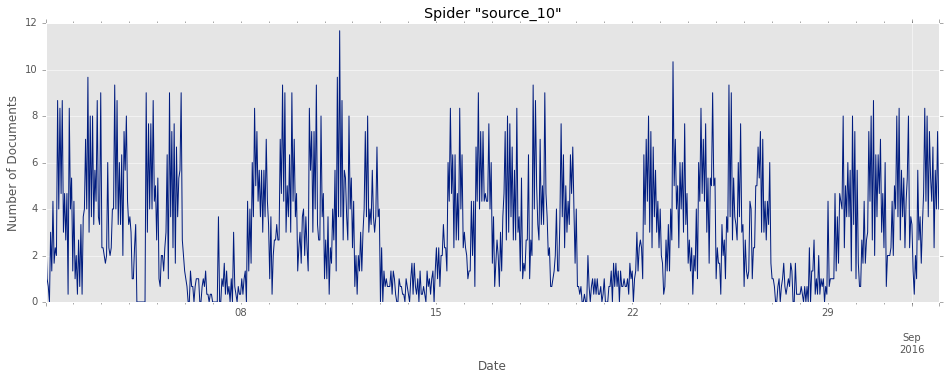

In [32]:
s.get_ts().resample('1H').plot(figsize=(16,5))
plt.title('Spider "%s"' % s._id)
plt.ylabel('Number of Documents')
plt.xlabel('Date')

In [33]:
s.get_dq()

,coherence,completeness
0,0.983231,0.886331


In [34]:
s.get_dq_by_attrs()

,attr,completeness,coherence
0,body,0.374822,0.910894
1,date_published,1.000000,1.000000
2,language,1.000000,0.998437
3,title,1.000000,1.000000
4,url,1.000000,1.000000


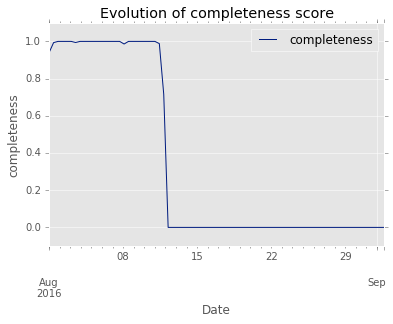

In [35]:
s.plot_dq_evolution_for_attr('completeness', 'body', freq='10H')
plt.ylabel('completeness')
plt.title('Evolution of completeness score')

Somehow the crawler started failing in fetching the body attribute. This project can be extended for alerting the manager when things like this come up.

----

### Conclusion

This library provides useful routines for measuring the quality of extraction for web crawlers. Be aware that it's in early development and therefore have limitations and possible bugs.

Hopefully this tutorial was helpful =]